In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [100]:
def stumpClassifier(dataMat, j, threshold, inequality):
    m, n = dataMat.shape
    predictedValue = np.ones((m, 1))
    if inequality == 'left':
        predictedValue[dataMat[:, j] <= threshold] = -1
    else:
        predictedValue[dataMat[:, j] > threshold] = -1
    return predictedValue

def bestClassifier(dataMat, yMat, D):
    m, n = dataMat.shape
    minError = np.Inf
    bestThreshold = np.Inf
    bestdirection = ''
    col = -1 #record whch column is best for classify
    for j in range(n):
        maxValue = dataMat[:, j].max()
        minValue = dataMat[:, j].min()
        interval = maxValue - minValue
        step = round(interval / m, 2)
        for s in range(-1, int(interval) + 2):
            for inequality in ['left', 'right']:                
                threshold = minValue + float(step) * s
                predictedValue = stumpClassifier(dataMat, j, threshold, inequality)
                error = np.ones((m, 1))
                error[predictedValue == yMat] = 0
                weightedError = D.T * error
                if weightedError < minError:
                    minError = weightedError
                    col = j
                    bestThreshold = threshold
                    bestdirection = inequality
                    bestPredictedValue = predictedValue.copy()
    return col, bestThreshold, bestPredictedValue, bestdirection, float(minError)

def AdaBoostClassifier(dataMat, labels):
    Classifier = []
    xMat = np.mat(dataMat)
    yMat = np.mat(labels).T
    m, n = xMat.shape
    D = np.mat(np.ones((m, 1)) / m)
    aggPredictedValue = np.mat(np.zeros((m, 1)))
    for i in range(10):
        col, threshold, predictedValue, direction, error = bestClassifier(dataMat, yMat, D)
        alpha = 0.5 * np.log((1-error)/max(error, 1e-16))
        colCopy = dataMat[:, col].copy()
        temp = np.multiply(-alpha * yMat, predictedValue)
        D = np.multiply(D, np.exp(temp))
        D = D / D.sum()
        Classifier.append([col, threshold, alpha, direction])
        aggPredictedValue += alpha * predictedValue
        aggregateError = np.multiply(np.sign(aggPredictedValue) != yMat, np.ones((m, 1)))
        errorRates = aggregateError.sum() / m
        if errorRates == 0:
            break
    return Classifier, aggPredictedValue

def AdaClassify(testPoint, Classifiers):
    aggPredictedValue = 0
    for clf in Classifiers:
        aggPredictedValue += clf[2] * stumpClassifier(np.mat(testPoint), clf[0], clf[1], clf[3])
    return np.sign(aggPredictedValue)

def HorseColic():
    data = np.loadtxt('horseColicTraining2.txt')
    trainMat = np.mat(data[:, :-1])
    trainLabel = data[:, -1]
    classifiers, predictedValue = AdaBoostClassifier(trainMat, trainLabel)
    ROC(predictedValue, trainLabel)
    data = np.loadtxt('horseColicTest2.txt')
    testArr = data[:, :-1]
    testLabel = data[:, -1]
    error = 0
    for i in range(testArr.shape[0]):
        if AdaClassify(testArr[i], classifiers) != testLabel[i]:
            error += 1
    print('Error rate is {}'.format(error/testArr.shape[0]))

def ROC(predictedValue, labels):
    cur = [1, 1]
    xStep = float(-1/trainLabel[trainLabel == -1].sum())
    yStep = float(1/trainLabel[trainLabel == 1].sum())
    indexSorted = predictedValue.T.argsort().tolist()[0]
    ySum = 0
    fig = plt.figure()
    ax = fig.add_subplot(111)
    for i in indexSorted:
        if labels[i] == 1:
            deltaX = 0
            deltaY = yStep
        else:
            deltaX = xStep
            deltaY = 0
            ySum += cur[1]
        ax.plot([cur[0], cur[0]-deltaX], [cur[1], cur[1]-deltaY], c = 'blue')
        cur = [cur[0]-deltaX, cur[1]-deltaY]
    ax.plot([0, 1], [0, 1], 'b--')
    plt.xlabel('FPR (False Positive Rate)')
    plt.ylabel('TPR(True Positive Rate)')
    plt.title('Receiver Operating Characteristic curve')
    plt.text(0.5, 0.2, 'AUC is {}'.format(round(ySum * xStep, 3)))

Error rate is 0.208955223880597


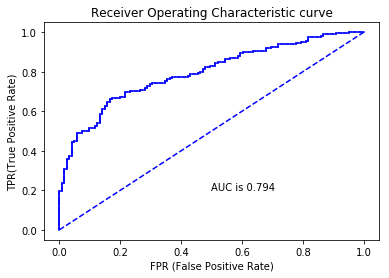

In [101]:
HorseColic()